# 1. Business Understanding

Much of the research on business success focuses on the success of companies and SMEs. In this context, the health of a company in a competitive business environment is highly associated with its profitability and level of solvency. Butler and Fitzgerald associate business success with the firm's competitive performance against its peers. Lussier and Pfeifer consider companies successful if they have generated at least the industry average profit over the past 3 years. Gatev et al., on the other hand, define success as continuing to operate without having debts to creditors and shareholders

# 2. Data and Data Understanding

The System, like most machine learning systems, starts with the data. This data set is provided by Crunchbase as an open source database in the form of 11 contiguous CSV files. Which is why the first step of data preparation is a merge into one CSV file, following which redundant and erroneous data as well as outliers are removed and a representative dataset is created.The dataset used in this case study contains details on various aspects of startups such as the year founded, funding received, current operating status and many other similar aspects.
The merged dataset contain industry trends, investment insights and individual company information. There are 48 columns and 922 rows. The target variable is status, if a startup is acquired by another organization, means that the startup is successful. In the existing dataset we can also find 3 different data types like inter, object and float.

## 2.1 Import of Relevant Modules

In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
#from project_lib import Project
#project = Project(project_id='58cfadef-0dab-4f52-815b-d168d148c073', project_access_token='p-903376f94368bc4ec9552b4ef639cf7876172d2a')
#pc = project.project_context


In [25]:
import numpy as np # linear algebra
import pandas as pd 
from sklearn.model_selection import train_test_split
import math
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt  # Matlab-style plotting
import plotly.offline as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
# import plotly.tools as tls
sns.set(style='white', context='notebook', palette='deep')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)
Random_state=42
np.random.seed(0)

In [3]:
#Models import
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
#import imputer:
from sklearn.impute import KNNImputer
#score
from sklearn.metrics import f1_score
from sklearn.ensemble import StackingClassifier

## 2.2 Read Data

In [4]:
# Cloud: Fetch the file
#my_file = project.get_file("startup data.csv")

# Cloud: Read the CSV data file from the object storage into a pandas DataFrame
#my_file.seek(0)



dataset=pd.read_csv('https://storage.googleapis.com/ml-service-repository-datastorage/Prediction_of_Successful_or_Failed_Startups_data.csv', converters={'status': lambda x: int(x == 'acquired')}, parse_dates=['founded_at','first_funding_at','last_funding_at'])
dataset.head()


,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,1
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,1
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,1
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,1
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,0


In [6]:
def attribute_description(data):
    longestColumnName = len(max(np.array(data.columns), key=len))
    print("| Feature  | Data Type|")
    print("|-----|------|")
    for col in data.columns:
        description = ''
        col_dropna = data[col].dropna()
        example = col_dropna.sample(1).values[0]
        if type(example) == str:
            description = 'str '
            if len(col_dropna.unique()) < 10:
                description += '{'
                description += '; '.join([ f'"{name}"' for name in col_dropna.unique()])
                description += '}'
            else:
                description += '[ example: "'+ example + '" ]'
        elif (type(example) == np.int32) and (len(col_dropna.unique()) < 10) :
            description += 'dummy int32 {'
            description += '; '.join([ f'{name}' for name in sorted(col_dropna.unique())])
            description += '}'
        else:
            try:
                description = example.dtype
            except:
                 description = type(example)
        print("|" + col.ljust(longestColumnName)+ f'|   {description}  |')
 
attribute_description(dataset)

| Feature  | Data Type|
|-----|------|
|Unnamed: 0              |   int64  |
|state_code              |   str [ example: "WA" ]  |
|latitude                |   float64  |
|longitude               |   float64  |
|zip_code                |   str [ example: "92101" ]  |
|id                      |   str [ example: "c:63731" ]  |
|city                    |   str [ example: "San Francisco" ]  |
|Unnamed: 6              |   str [ example: "San Francisco CA 94103" ]  |
|name                    |   str [ example: "Lazarus Therapeutics" ]  |
|labels                  |   int64  |
|founded_at              |   datetime64[ns]  |
|closed_at               |   str [ example: "5/1/2013" ]  |
|first_funding_at        |   datetime64[ns]  |
|last_funding_at         |   datetime64[ns]  |
|age_first_funding_year  |   float64  |
|age_last_funding_year   |   float64  |
|age_first_milestone_year|   float64  |
|age_last_milestone_year |   float64  |
|relationships           |   int64  |
|funding_rounds          

In [7]:
print(dataset.isnull().sum())

Unnamed: 0                    0
state_code                    0
latitude                      0
longitude                     0
zip_code                      0
id                            0
city                          0
Unnamed: 6                  493
name                          0
labels                        0
founded_at                    0
closed_at                   588
first_funding_at              0
last_funding_at               0
age_first_funding_year        0
age_last_funding_year         0
age_first_milestone_year    152
age_last_milestone_year     152
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
state_code.1                  1
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
category_code                 0
is_software                   0
is_web                        0
is_mobil

In [8]:
dataset.rename(columns={'status':'is_acquired'}, inplace=True)

## 2.3 Descriptive Analysis

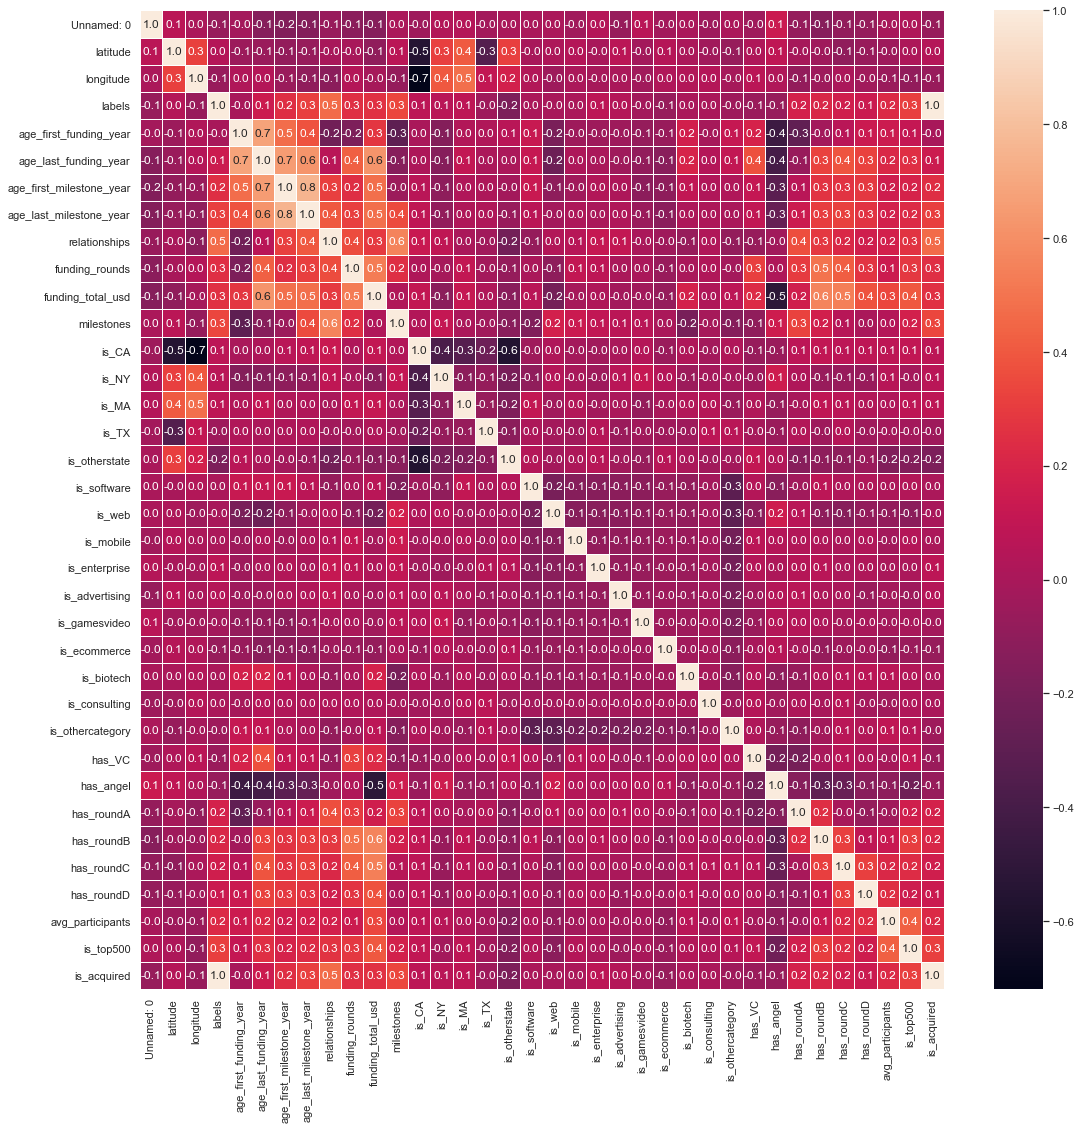

In [9]:
def draw_heatmap(dataset):
    
    
    f, ax = plt.subplots(figsize = (18, 18))
    
    corrMatt = dataset.corr(method='spearman')
    
    sns.heatmap(corrMatt, annot = True, linewidth = 0.5, fmt = '.1f', ax = ax)
    plt.show()
    
    
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
numerical_df_1=dataset.select_dtypes(numerics)
numerical_column_names = dataset.select_dtypes(numerics).columns

draw_heatmap(numerical_df_1)


### 2.3.1 Detect outliers from numeric variables


In [10]:
def getOutliersMatrix(numerical_df, threshold=1.5):
    Q1 = numerical_df.quantile(0.25)
    Q3 = numerical_df.quantile(0.75)
    IQR = Q3 - Q1
    
    outdata = (numerical_df < (Q1 - 1.5 * IQR)) | (numerical_df > (Q3 + 1.5 * IQR))
    
    for name in numerical_df.columns:
        outdata.loc[(outdata[name] == True), name] = 1
        outdata.loc[(outdata[name] == False), name] = 0
    
    return outdata


outliersMatt = getOutliersMatrix(numerical_df_1)


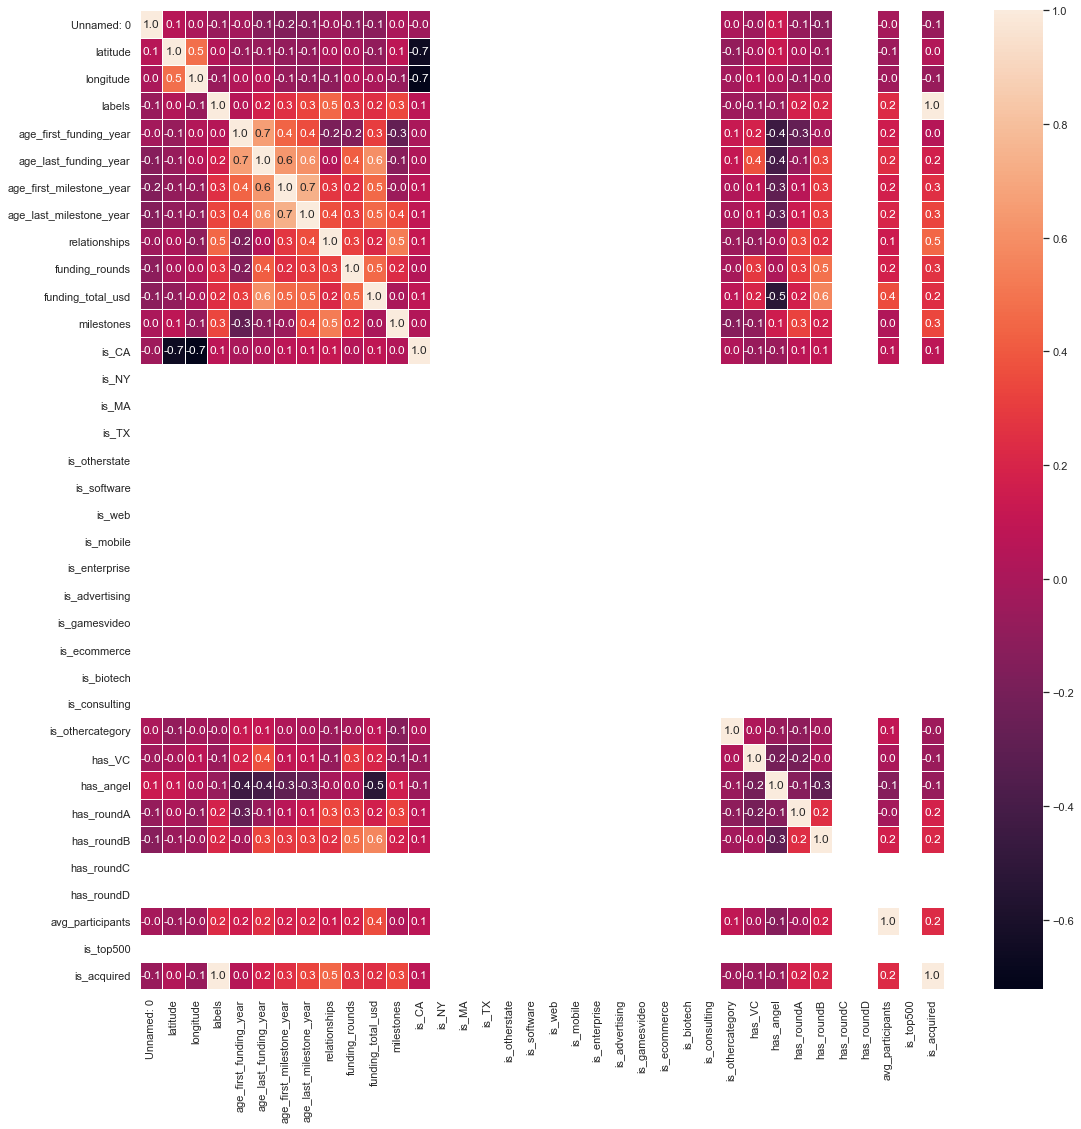

In [11]:
outliersMatt = getOutliersMatrix(numerical_df_1)

dataset[outliersMatt==1]= np.nan

numerical_df_2=dataset.select_dtypes(numerics)

draw_heatmap(numerical_df_2)

Alle Ausreißerpunkte mit fehlenden Werten zu ergänzen, die Ausreißerpunkte werden durch den IQR-Test erkannt.
Nach der Datenverarbeitung werden die insgesamt fehlenden Daten ergänzt.

### 2.3.2 Data processing


Wenn Sie die Spalten "Unnamed: 0" und "Unnamed: 6" entfernen, hat Unnamed: 6 493 fehlende Daten, da wir keine Informationen über diese Spalte haben.
Unnamed:0 ist unbekannt. 

In [12]:
dataset.drop(["Unnamed: 6"],axis=1, inplace=True)
dataset.drop(["Unnamed: 0"], axis=1, inplace=True)
comparison_column = np.where(dataset["state_code"] != dataset["state_code.1"], True, False)
dataset[comparison_column]['state_code.1']
dataset.drop(["state_code.1"], axis=1, inplace=True)

Check for Null values


In [13]:
print(dataset.isnull().sum())

state_code                    0
latitude                     78
longitude                     4
zip_code                      0
id                            0
city                          0
name                          0
labels                        0
founded_at                    0
closed_at                   588
first_funding_at              0
last_funding_at               0
age_first_funding_year       21
age_last_funding_year        12
age_first_milestone_year    169
age_last_milestone_year     159
relationships                60
funding_rounds               16
funding_total_usd            65
milestones                    1
is_CA                         0
is_NY                       106
is_MA                        83
is_TX                        42
is_otherstate               204
category_code                 0
is_software                 153
is_web                      144
is_mobile                    79
is_enterprise                73
is_advertising               62
is_games

# 3. Data Preparation

In [14]:
def imputing_numeric_missing_values(dataset,n_neighbors=10):
    numerical_column_names = dataset.select_dtypes([np.number]).columns
    knn= KNNImputer()
    knn_dataset= knn.fit_transform(dataset[numerical_column_names])
    
    dataset[numerical_column_names]=pd.DataFrame(knn_dataset)
    return dataset

dataset=imputing_numeric_missing_values(dataset)

numerical_df_3=dataset.select_dtypes(numerics)

# Check for Null values
print(dataset.isnull().sum())

state_code                    0
latitude                      0
longitude                     0
zip_code                      0
id                            0
city                          0
name                          0
labels                        0
founded_at                    0
closed_at                   588
first_funding_at              0
last_funding_at               0
age_first_funding_year        0
age_last_funding_year         0
age_first_milestone_year      0
age_last_milestone_year       0
relationships                 0
funding_rounds                0
funding_total_usd             0
milestones                    0
is_CA                         0
is_NY                         0
is_MA                         0
is_TX                         0
is_otherstate                 0
category_code                 0
is_software                   0
is_web                        0
is_mobile                     0
is_enterprise                 0
is_advertising                0
is_games

Alle Nan-Stellen ausgefüllt haben, außer für closed_at, da es nicht numerisch ist

### Konvertiert closed_at-Werte in einer Spalte in Binärwerte. 
Der Wert nan bedeutet, dass das Startup noch in Betrieb ist. 
Außerdem kann der Wert none nicht für die Zeitdatenanalyse verwendet werden.

In [15]:
dataset['closed_at']=dataset['closed_at'].fillna('temporary')
dataset['closed_at'] = dataset.closed_at.apply(lambda x: 1 if x =='temporary' else 0)

### Umgang mit Zeitreihen-Features
Konvertieren in numerische Zahlen, indem Sie neue Features hinzufügen und erstellen:

In [16]:
dataset['months_between_first_and_last_funding'] = ((dataset.last_funding_at - dataset.first_funding_at)/np.timedelta64(1, 'M'))
dataset['months_between_foundation_and_first_funding']=((dataset.first_funding_at - dataset.founded_at)/np.timedelta64(1, 'M'))

In [17]:
#delete unnecessary data
dataset.drop(["last_funding_at"],axis=1, inplace=True)
dataset.drop(["first_funding_at"], axis=1, inplace=True)
dataset.drop(["founded_at"], axis=1, inplace=True)


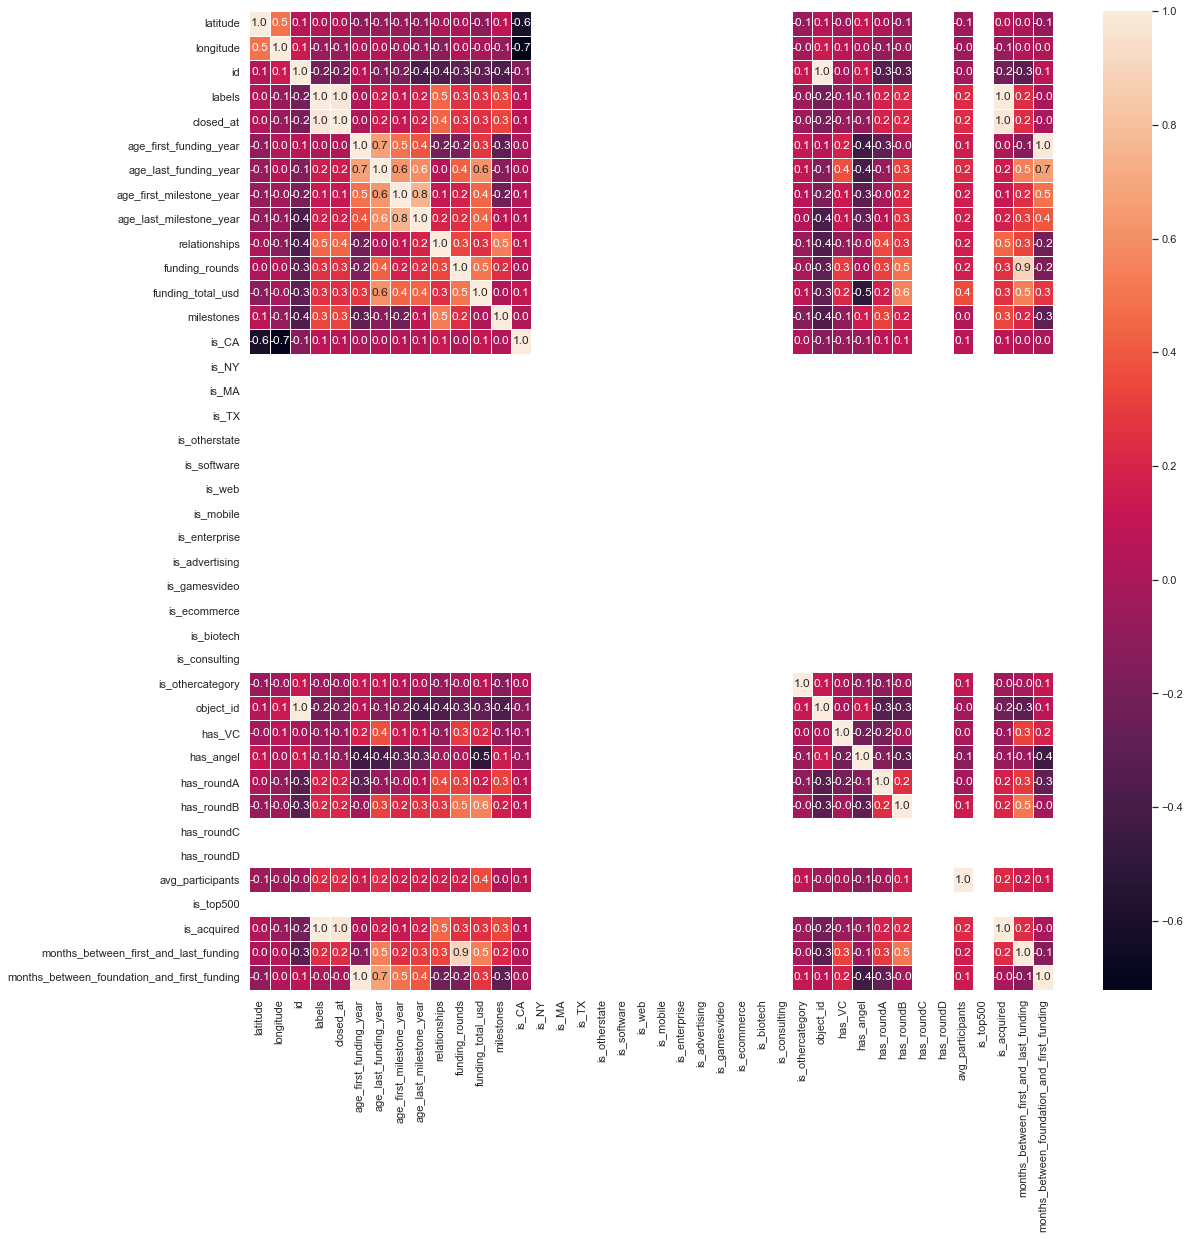

In [18]:
#convert object_id to numeric:
dataset['object_id'] = dataset['object_id'].str.replace("c:", '').astype(int)
dataset['id'] = dataset['id'].str.replace("c:", '').astype(int)

numerical_df_4=dataset.select_dtypes(numerics)
draw_heatmap(numerical_df_4)

# Create correlation matrix
corr_matrix = numerical_df_4.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.loc["is_acquired"]
upper=upper.fillna(0)
upper=upper.to_dict()
# Find features with correlation greater than 0.95
to_drop = [key for key in upper if upper[key]< 0.2]


#### Features zum löschen

In [19]:
print(to_drop)

['latitude', 'longitude', 'id', 'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year', 'age_last_milestone_year', 'funding_total_usd', 'is_CA', 'is_NY', 'is_MA', 'is_TX', 'is_otherstate', 'is_software', 'is_web', 'is_mobile', 'is_enterprise', 'is_advertising', 'is_gamesvideo', 'is_ecommerce', 'is_biotech', 'is_consulting', 'is_othercategory', 'object_id', 'has_VC', 'has_angel', 'has_roundA', 'has_roundC', 'has_roundD', 'is_top500', 'months_between_foundation_and_first_funding']


#### Drop features 


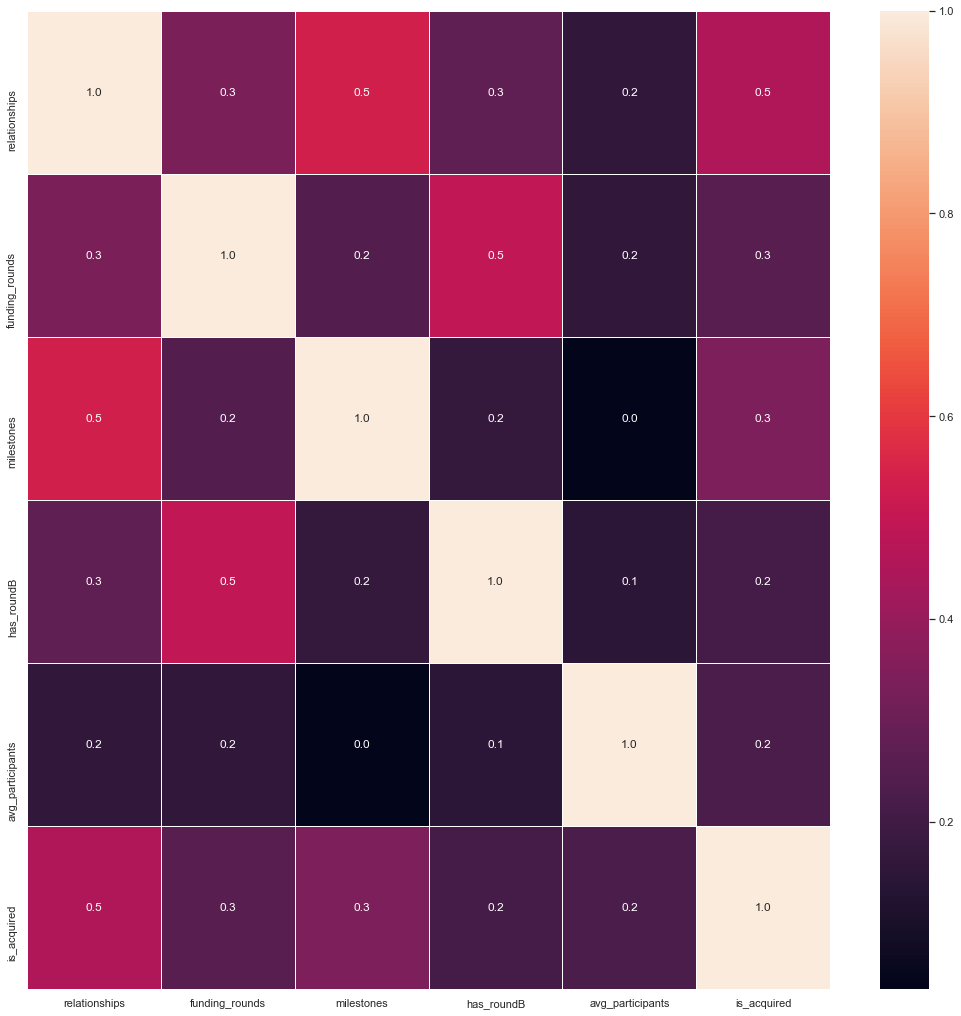

In [20]:
dataset.drop(to_drop, axis=1, inplace=True)
numerical_df_5=dataset.select_dtypes(numerics)
dataset.drop(["labels"], axis=1, inplace=True)
dataset.drop(["closed_at"], axis=1, inplace=True)
dataset.drop(["months_between_first_and_last_funding"], axis=1, inplace=True) #corelated to founding_rounds
numerical_df_5=dataset.select_dtypes(numerics)
draw_heatmap(numerical_df_5)

dataset=pd.get_dummies(dataset)

# 4. Modelling and Evaluation


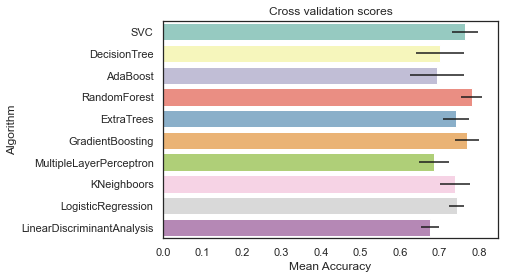

In [21]:
y=dataset["is_acquired"]
X= dataset.loc[:, dataset.columns != 'is_acquired']
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2, random_state=42)

# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")
plt.show()

Ich habe mich für die SVC ,RandomForest,ExtraTrees und die GradientBoosting-Klassifikatoren für die Ensemble-Modellierung entschieden.


In [22]:
best_classifiers=[]
# Adaboost

### META MODELING
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsadaDTC.fit(X_train,y_train)

ada_best = gsadaDTC.best_estimator_

# Best score
print("Adaboost score: "+str(gsadaDTC.best_score_))


### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsSVMC.fit(X_train,y_train)

SVMC_best = gsSVMC.best_estimator_

best_classifiers.append(SVMC_best)

# Best score
SVC_score = gsSVMC.best_score_

print(f' SVC classifier score is :{SVC_score}')

#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [1,2,4],
              "max_features": [1,100,1000],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsExtC.fit(X_train,y_train)

ExtC_best = gsExtC.best_estimator_

best_classifiers.append(ExtC_best)

# Best score

ExtraTrees_score= gsExtC.best_score_

print(f' ExtraTrees score is :{ExtraTrees_score}')

# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [1,2,4],
              "max_features": [1, 10,100,1000],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_
best_classifiers.append(RFC_best)

# Best score

RandomForests_score= gsRFC.best_score_

print(f' RandomForests score is :{RandomForests_score}')

# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,1000],
              'learning_rate': [0.001,0.1, 0.05, 0.01,1,10],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= -1, verbose = 1)

gsGBC.fit(X_train,y_train)

GBC_best = gsGBC.best_estimator_
best_classifiers.append(GBC_best)

# Best score

GradientBoosting_score= gsGBC.best_score_

print(f' GradientBoosting score is :{GradientBoosting_score}')

Fitting 10 folds for each of 112 candidates, totalling 1120 fits
Adaboost score: 0.7317289892632358
Fitting 10 folds for each of 28 candidates, totalling 280 fits
 SVC classifier score is :0.7764716771566087
Fitting 10 folds for each of 162 candidates, totalling 1620 fits
 ExtraTrees score is :0.7722880414661236
Fitting 10 folds for each of 216 candidates, totalling 2160 fits
 RandomForests score is :0.7669751943724548
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
 GradientBoosting score is :0.7669196593854128


## Interactive feature imports via Plotly scatter plots



Erstellen Sie einen Datenrahmen aus den Listen, der die Daten zur Merkmalsbedeutung enthält, um sie mit dem Plotly-Paket einfach aufzeichnen zu können.



In [26]:
def plotly_scatterplots(model_importances,model_title):
    trace = go.Scatter(
        y = feature_dataframe[model_importances].values,
        x = feature_dataframe['features'].values,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 25,
    #       size= feature_dataframe['AdaBoost feature importances'].values,
            #color = np.random.randn(500), #set color equal to a variable
            color = feature_dataframe[model_importances].values,
            colorscale='Portland',
            showscale=True
        ),
        text = feature_dataframe['features'].values
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= model_title,
        hovermode= 'closest',
    #     xaxis= dict(
    #         title= 'Pop',
    #         ticklen= 5,
    #         zeroline= False,
    #         gridwidth= 2,
    #     ),
        yaxis=dict(
            title= 'Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig,filename='scatter2010')

In [27]:
# Create a dataframe with features

cols = X_train.columns.values

rf_feature = RFC_best.feature_importances_
et_feature = ExtC_best.feature_importances_
ada_feature = ada_best.feature_importances_
gb_feature = GBC_best.feature_importances_

feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_feature,
     'Extra Trees  feature importances': et_feature,
      'AdaBoost feature importances': ada_feature,
    'Gradient Boost feature importances': gb_feature
    })
feature_dataframe = feature_dataframe[feature_dataframe.astype(bool).sum(axis=1) > feature_dataframe.shape[1]/(1.2)]
model_importances=['Random Forest feature importances','Extra Trees  feature importances','AdaBoost feature importances','Gradient Boost feature importances']
model_title=['Random Forest feature importance','Extra Trees  feature importance','AdaBoost feature importance','Gradient Boost feature importance']

for importances,title in zip(model_importances,model_title):
    
    plotly_scatterplots(importances,title)
    

In [28]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,features,Random Forest feature importances,Extra Trees feature importances,AdaBoost feature importances,Gradient Boost feature importances,mean
0,relationships,0.543653,0.409431,0.185131,0.513521,0.412934
1,funding_rounds,0.033786,0.062794,0.033113,0.082653,0.053086
2,milestones,0.145032,0.165001,0.050931,0.168289,0.132313


In [29]:
def mean_bar_plot(feature_dataframe):
    y = feature_dataframe['mean'].values
    x = feature_dataframe['features'].values
    data = [go.Bar(
                x= x,
                 y= y,
                width = 0.5,
                marker=dict(
                   color = feature_dataframe['mean'].values,
                colorscale='Portland',
                showscale=True,
                reversescale = False
                ),
                opacity=0.6
            )]

    layout= go.Layout(
        autosize= True,
        title= 'Barplots of Mean Feature Importance',
        hovermode= 'closest',
    #     xaxis= dict(
    #         title= 'Pop',
    #         ticklen= 5,
    #         zeroline= False,
    #         gridwidth= 2,
    #     ),
        yaxis=dict(
            title= 'Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='bar-direct-labels')

In [30]:
mean_bar_plot(feature_dataframe)

## Plot learning curves

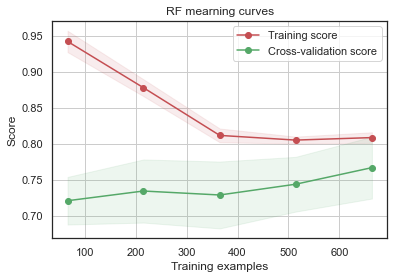

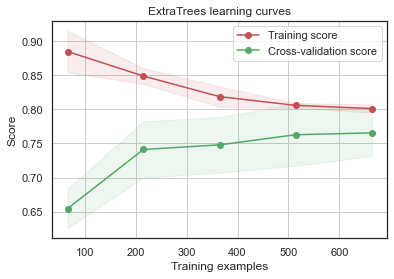

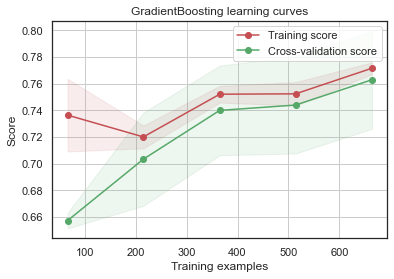

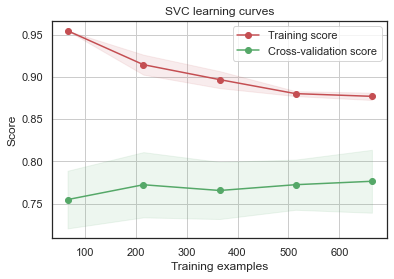

In [31]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, alpha=0.1,
                      color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
              label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
              label="Cross-validation score")

    plt.legend(loc="best")
    return plt


g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,y_train,cv=kfold)
plt.show()
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,y_train,cv=kfold)
plt.show()
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,y_train,cv=kfold)
plt.show()
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,y_train,cv=kfold)



Merkmalsbedeutung von baumbasierten Klassifikatoren


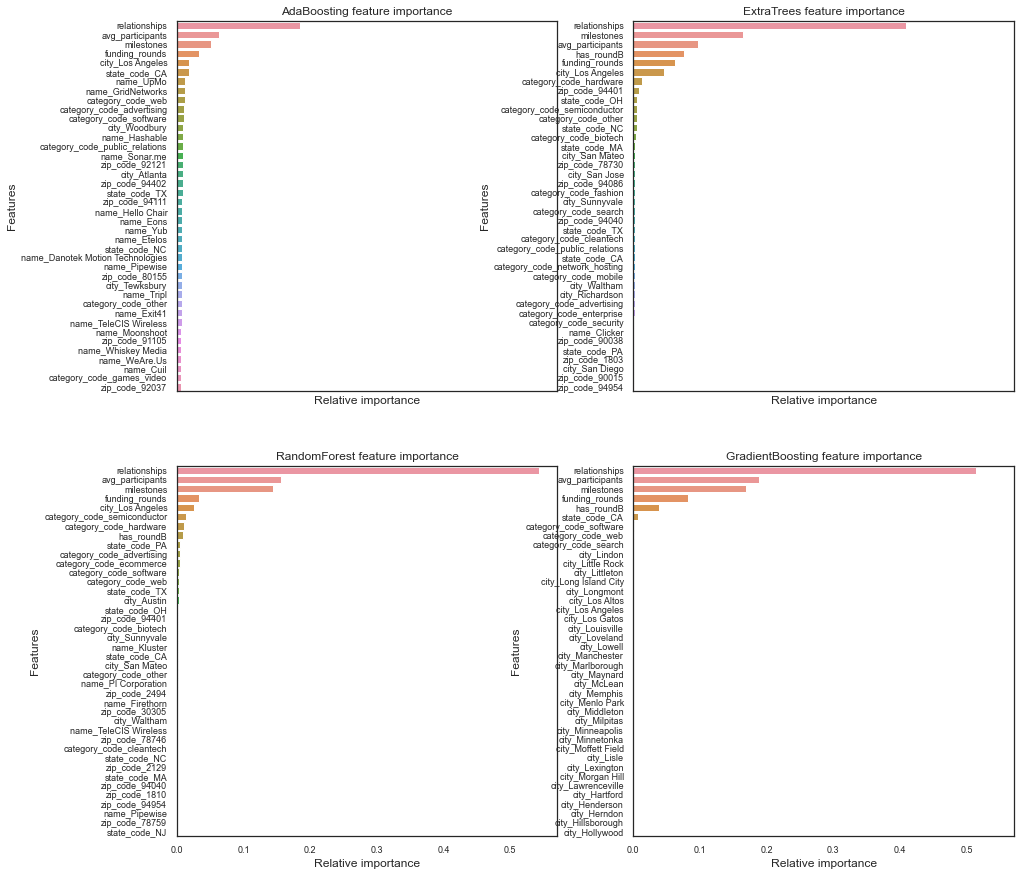

In [32]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1
        


test_is_acquired_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_is_acquired_ExtC = pd.Series(ExtC_best.predict(X_test), name="ExtC")
test_is_acquired_AdaC = pd.Series(ada_best.predict(X_test), name="Ada")
test_is_acquired_GBC = pd.Series(GBC_best.predict(X_test), name="GBC")

Verketten aller Klassifikatorergebnisse


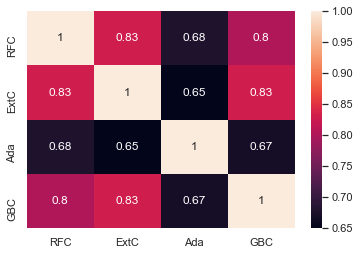

In [33]:
ensemble_results = pd.concat([test_is_acquired_RFC,test_is_acquired_ExtC,test_is_acquired_AdaC,test_is_acquired_GBC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

# Ensemble modeling

## Combining models

In [34]:
#voting Classifier:
 
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best)
,('gbc',GBC_best)], voting='soft', n_jobs=-1)

votingC = votingC.fit(X_train, y_train)

#stacking
def stacking(classifiers, X_train, X_test, y_train, y_test):
    all_estimators = []
    for classifier in classifiers:
        all_estimators.append((str(classifier), classifier))
    stack = StackingClassifier(estimators=all_estimators, final_estimator=GBC_best)
    score= stack.fit(X_train, y_train).score(X_test, y_test)
   
    return score


# Prediction

In [35]:
test_is_acquired = pd.Series(votingC.predict(X_test), name="is_acquired")

results = pd.concat([test_is_acquired],axis=1)

score= f1_score(y_test, results, average='macro')

stacking_score = stacking(best_classifiers, X_train, X_test, y_train, y_test)

print(f'the voting score is: {score}')

print(f'the stacking score is: {stacking_score} ') 

the voting score is: 0.7625160462130938
the stacking score is: 0.7891891891891892 


Es ist deutlich zu sehen, dass das Stapeln die besten Ergebnisse bei der Klassifizierung liefert